# Notebook for preprocessing the LOFAR catalogues before XID+

it outputs a modified LOFAR radio data table with two new columns. the first column is XID+_rerun and is a boolean array stating whether a source should ahve XID+ rerun or not. The second is a string column that says what where the fir for that source comes from.

In [39]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os
import pymoc
import mocpy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
#from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
#from herschelhelp_internal.utils import inMoc
from pymoc.io.fits import read_moc_fits



In [32]:
def best_irac(swire,servs):
    mask = np.isnan(swire)
    swire[mask] = 10000
    mask = np.isnan(servs)
    servs[mask] = 10000
    swire_mask = swire<servs
    return(swire_mask)

In [6]:
lofar = Table.read('data/LH_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_public.fits')

mask = ~np.isnan(lofar['F_SPIRE_250'])
c = SkyCoord(lofar['RA'][mask],lofar['DEC'][mask],unit='deg')
#spire_moc = pymoc.util.catalog.catalog_to_moc(c,15,12)
spire_moc = pymoc.moc.MOC()
read_moc_fits(spire_moc,'/lustre/scratch/astro/im281/HELP/dmu_products/dmu2/dmu2_field_coverages/Lockman-SWIRE_MOC.fits')
print('SPIRE covers: {}sq degrees'.format(spire_moc.area_sq_deg))

mask = ~np.isnan(lofar['F_PACS_100'])
c = SkyCoord(lofar['RA'][mask],lofar['DEC'][mask],unit='deg')
pacs_moc = pymoc.util.catalog.catalog_to_moc(c,15,12)
print('PACS covers: {}sq degrees'.format(pacs_moc.area_sq_deg))

mask = ~np.isnan(lofar['F_MIPS_24'])
c = SkyCoord(lofar['RA'][mask],lofar['DEC'][mask],unit='deg')
mips_moc = pymoc.util.catalog.catalog_to_moc(c,15,12)
print('MIPS covers: {}sq degrees'.format(mips_moc.area_sq_deg))

SPIRE covers: 22.413863402949218sq degrees
PACS covers: 10.331753949911489sq degrees
MIPS covers: 10.794021152937951sq degrees


In [4]:
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/Lockman-SWIRE/data/'

pswfits=imfolder+'wp4_lockman-swire_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header
mips_moc = mocpy.MOC.from_image(im250hdu,15)

mips_moc.write('data/data_release/final_mocs/mips_moc_Lockman.fits',format='fits',overwrite=True)

mips_moc = pymoc.moc.MOC()
read_moc_fits(mips_moc,'data/data_release/final_mocs/mips_moc_Lockman.fits')
print('MIPS covers: {}sq degrees'.format(mips_moc.area_sq_deg))

MIPS covers: 17.977005601837728sq degrees


In [5]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_HELP-PACS-maps/data/'

im100fits=imfolder + 'Lockman-SWIRE_PACS100_v0.9.fits'#PACS 100 map
#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[1].header
pacs_moc = mocpy.MOC.from_image(im100hdu,15)

pacs_moc.write('data/data_release/final_mocs/pacs_moc_Lockman.fits',format='fits',overwrite=True)

pacs_moc = pymoc.moc.MOC()
read_moc_fits(pacs_moc,'data/data_release/final_mocs/pacs_moc_Lockman.fits')
print('PACS covers: {}sq degrees'.format(pacs_moc.area_sq_deg))

PACS covers: 32.20707401227812sq degrees


In [6]:
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'

pswfits=imfolder+'Lockman-SWIRE_SPIRE250_v1.0.fits'#SPIRE 250 map

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header
spire_moc = mocpy.MOC.from_image(im250hdu,15)

spire_moc.write('data/data_release/final_mocs/spire_moc_Lockman.fits',format='fits',overwrite=True)

spire_moc = pymoc.moc.MOC()
read_moc_fits(spire_moc,'data/data_release/final_mocs/spire_moc_Lockman.fits')
print('SPIRE covers: {}sq degrees'.format(spire_moc.area_sq_deg))

SPIRE covers: 36.20155006580141sq degrees


## Read in the LOFAR catalogues and work out which sources need to be rerun 

In [33]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]
print(len(lofar))

ras = lofar['optRA']
mask = np.isnan(ras)
print(np.sum(mask))
ras[mask] = lofar['RA'][mask]

decs = lofar['optDec']
mask = np.isnan(decs)
print(np.sum(mask))
decs[mask] = lofar['DEC'][mask]

ids = lofar['Source_Name']

4723
459
459


In [34]:
cra = Column(ras,name='ra')
cdec = Column(decs,name='dec')
cids = Column(ids,name='help_id')
cdet = Column(np.zeros(len(ras))-99,name='flag_optnir_det')
cmips = Column(np.zeros(len(ras))*np.nan,name='f_mips_24')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,cmips])

## Read in the HELP masterlist

In [42]:
columns = 'ra','dec','help_id','flag_optnir_det','f_irac_i1','f_irac_i2','f_irac_i3','f_irac_i4','f_mips_24','f_pacs_green','f_pacs_red'
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Bootes/data/Bootes_20190701_cigale.fits')
help_masterlist = masterlist[columns]
help_masterlist[0]

ra,dec,help_id,flag_optnir_det,f_irac_i1,f_irac_i2,f_irac_i3,f_irac_i4,f_mips_24,f_pacs_green,f_pacs_red
deg,deg,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy
float64,float64,bytes27,int64,float64,float64,float64,float64,float32,float32,float32
215.88182119597099,35.4097963240682,HELP_J142331.637+352435.267,1,nan,nan,nan,nan,nan,nan,nan


## Create the prior catalogue using the MIPS priors

In [36]:
mips_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)

prior_cat = help_masterlist[mips_mask]
print('number of help prior sources is: {}'.format(len(prior_cat)))

number of help prior sources is: 495159


In [37]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

499882

In [38]:
Table.write(prior_cat,'data/data_release/xidplus_prior_cat_rerun_mips.fits',overwrite=True)

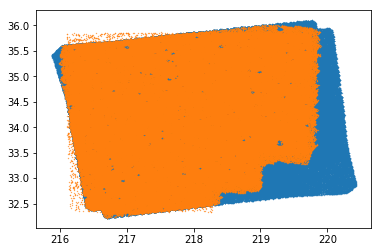

In [9]:
x = help_masterlist['ra']
y = help_masterlist['dec']
plt.scatter(x,y,s=0.1)

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1)
plt.show()

In [ ]:
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1)

mask = ~np.isnan(help_masterlist['f_pacs_red'])
x = help_masterlist['ra'][mask]
y = help_masterlist['dec'][mask]
plt.scatter(x,y,s=0.1)

plt.scatter(ras,decs,c='green',s=1)
plt.show()

## Create the prior catalogue using the Ldust priors

In [33]:
ldust = Table.read('../../../../../HELP/dmu_products/dmu28/dmu28_Lockman-SWIRE/data/Lockman-SWIRE_Ldust_prediction_results.fits')
ldust.rename_column('id','help_id')
for n in range(len(ldust)):
    ldust[n]['help_id']=ldust[n]['help_id'].replace(' ','')

In [34]:
ldust_coords = join(ldust,help_masterlist,keys='help_id',join_type='left')

In [37]:
ldust_coords[0]

help_id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,best.chi_square,best.reduced_chi_square,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.wfc_u,best.megacam_u,best.megacam_g,best.gpc1_g,best.wfc_g,best.gpc1_r,best.wfc_r,best.megacam_r,best.gpc1_i,best.megacam_i,best.megacam_y,best.wfc_i,best.gpc1_z,best.wfc_z,best.megacam_z,best.gpc1_y,best.ukidss_j,best.ukidss_k,best.irac_i1,best.irac_i2,best.irac_i3,best.irac_i4,best.mips_24,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500,ra,dec,flag_optnir_det,f_mips_24
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,deg,deg,,uJy
bytes33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float32
HELP_J103755.490+592806.025,5604412346.505531,1070659840.429403,5.845980012139975,6.010488895730351,2.003748523970805e+37,1.3759500905290382e+37,75.78360855764737,18.945902139411842,2.8,0.5,1.896233573947713,4.491140701590342,-0.7,-0.7,1.1367687579411335e+37,1.2326699066642044e+37,2.0,0.02,2.369438664605338e+37,1.2937072401026876e+38,0.47,5.0,0.0,0.0,2500.0,10.0,0.001,9158179043.325256,6.351138944998894,5.507923162086263,6.349904297712362,10000.0,3000.0,907.548715023767,1.0,2.58301271179141e+36,1.355117639488918e+34,2.569461535396521e+36,3402142331.604237,3398017545.981012,4124785.6232251436,5756036668.891398,5696662454.367122,59374214.52427643,0.02,7.909108234720333e+53,4.06161354487228e+51,7.86849209927161e+53,10.0,7527.949072306243,1.2775728113550273e+26,0.68,0.00022993478651882037,0.0002440554965314313,0.0004048585617593933,0.00040636627766923723,0.00040743933416579947,0.0008730861915721103,0.0008718679753063824,0.0008871033886155384,0.001870919806343346,0.001862288665271551,0.0019313356246307095,0.0019359142594710939,0.0023019628418220945,0.0023078902290584466,0.002390749080629269,0.002732844756374034,0.003823753093091422,0.006800458449608271,0.007565527949133713,0.005584428627091305,0.005121825268087085,0.005815289504854415,0.0568758741497294,2.045884151785734,4.039374641860336,3.738050847993529,2.20094672000906,0.9944247615450231,159.4812079600245,59.46834031574975,3,nan


In [38]:
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
f_pred=ldust_coords['bayes.dust.luminosity']/(4*np.pi*cosmo.luminosity_distance(ldust_coords['best.universe.redshift']).to(u.cm))

In [39]:
prior=ldust_coords[np.isfinite(f_pred.value)][np.log10(f_pred.value[np.isfinite(f_pred.value)])>8.5]

In [44]:
cols = ['help_id','ra','dec']
prior_cat = prior[cols]

In [46]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

159971

In [48]:
Table.write(prior_cat,'data/data_release/xidplus_prior_cat_rerun_ldust.fits',overwrite=True)

## Create the prior for the MIPS rerun

In [21]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_MIPS_24']))
lofar = lofar[~mask]
print(len(lofar))

ras = lofar['optRA']
mask = np.isnan(ras)
print(np.sum(mask))
ras[mask] = lofar['RA'][mask]

decs = lofar['optDec']
mask = np.isnan(decs)
print(np.sum(mask))
decs[mask] = lofar['DEC'][mask]

ids = lofar['Source_Name']

3849
459
459


In [22]:
mips_mask = (help_masterlist['flag_optnir_det']>=5)

prior_cat = help_masterlist[mips_mask]
print('number of help prior sources is: {}'.format(len(prior_cat)))

number of help prior sources is: 1643955


In [23]:
MIPS_lower=np.full(len(prior_cat),0.0)
MIPS_upper=np.full(len(prior_cat),1E5)
for i in range(len(prior_cat)):
    if np.isnan(prior_cat['f_irac_i4'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i4'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i4'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i3'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i3'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i3'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i2'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i2'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i2'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i1'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i1'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i1'][i]*500.0
        
mips_lower_col = Column(MIPS_lower,name='MIPS_lower')
mips_upper_col = Column(MIPS_upper,name='MIPS_upper')
prior_cat.add_columns([mips_lower_col,mips_upper_col])

In [24]:
lofar

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ALPHA_J2000,DELTA_J2000,FLAG_DEEP,flag_clean,ID_OPTICAL,ID_SPITZER,ID,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,Bw_flux_corr,Bw_fluxerr_corr,Bw_mag_corr,Bw_magerr_corr,R_flux_corr,R_fluxerr_corr,R_mag_corr,R_magerr_corr,I_flux_corr,I_fluxerr_corr,I_mag_corr,I_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,z_Subaru_flux_corr,z_Subaru_fluxerr_corr,z_Subaru_mag_corr,z_Subaru_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,H_flux_corr,H_fluxerr_corr,H_mag_corr,H_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,Ks_flux_corr,Ks_fluxerr_corr,Ks_mag_corr,Ks_magerr_corr,ch1_flux_corr,ch1_fluxerr_corr,ch1_mag_corr,ch1_magerr_corr,ch2_flux_corr,ch2_fluxerr_corr,ch2_mag_corr,ch2_magerr_corr,ch3_flux_corr,ch3_fluxerr_corr,ch3_mag_corr,ch3_magerr_corr,ch4_flux_corr,ch4_fluxerr_corr,ch4_mag_corr,ch4_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,RA_ZSPEC,DEC_ZSPEC,REL,OBJID,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,AGN_ZSPEC,XrayAGN,XrayFlux_0.5-2,XrayHardness,hp_idx_11,hp_depth_cluster,tot_corr_z_Subaru,tot_corr_err_z_Subaru,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,Bw_rest,R_rest,I_rest,z_rest,z_Subaru_rest,y_rest,J_rest,H_rest,K_rest,Ks_rest,ch1_rest,ch2_rest,ch3_rest,ch4_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,float64,float64,float64,int64,int64,int64,float64,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

In [25]:
i1_f = lofar['ch1_flux_corr']

i2_f = lofar['ch2_flux_corr']

i3_f = lofar['ch3_flux_corr']

i4_f = lofar['ch4_flux_corr']

In [26]:
cra = Column(ras,name='ra')
cdec = Column(decs,name='dec')
cids = Column(ids,name='help_id')
cdet = Column(np.zeros(len(ras))-99,name='flag_optnir_det')
ci1 = Column(i1_f,name='f_irac_i1')
ci2 = Column(i2_f,name='f_irac_i2')
ci3 = Column(i3_f,name='f_irac_i3')
ci4 = Column(i4_f,name='f_irac_i4')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,ci1,ci2,ci3,ci4])

In [27]:
MIPS_lower=np.full(len(lofar_prior),0.0)
MIPS_upper=np.full(len(lofar_prior),1E5)
for i in range(len(lofar_prior)):
    if np.isnan(lofar_prior['f_irac_i4'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i4'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i4'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i3'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i3'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i3'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i2'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i2'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i2'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i1'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i1'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i1'][i]*500.0
        
mips_lower_col = Column(MIPS_lower,name='MIPS_lower')
mips_upper_col = Column(MIPS_upper,name='MIPS_upper')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,ci1,ci2,ci3,ci4,mips_lower_col,mips_upper_col])

In [28]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

1647804

In [29]:
prior_cat

ra,dec,help_id,flag_optnir_det,f_irac_i1,f_irac_i2,f_irac_i3,f_irac_i4,f_mips_24,MIPS_lower,MIPS_upper
deg,deg,,,uJy,uJy,uJy,uJy,uJy,,
float64,float64,bytes27,float64,float64,float64,float64,float64,float32,float64,float64
215.98034637597098,35.24606363406821,HELP_J142355.283+351445.829,5.0,nan,75.9898439473133,nan,24.2634127557033,nan,0.0485268255114066,12131.70637785165
215.98377009597098,35.25453661406821,HELP_J142356.105+351516.332,5.0,nan,305.326463282883,nan,95.2421844747383,67.09552,0.1904843689494766,47621.09223736915
215.98399555597098,35.2464263940682,HELP_J142356.159+351447.135,5.0,nan,299.771333969483,nan,77.2440070448367,nan,0.15448801408967341,38622.00352241835
215.99260956597098,35.2599410840682,HELP_J142358.226+351535.788,5.0,nan,35.7791283736967,nan,25.2646954360217,536.5018,0.0505293908720434,12632.34771801085
215.99734143597098,35.23536844406821,HELP_J142359.362+351407.326,5.0,69.7791238472183,nan,54.389837210805,nan,144.67899,0.10877967442160999,27194.918605402498
215.997465825971,35.2550397640682,HELP_J142359.392+351518.143,5.0,nan,214.0883838922,nan,42.9535476343467,41.669342,0.08590709526869339,21476.77381717335
215.99784159597098,35.285312194068204,HELP_J142359.482+351707.124,5.0,nan,10.6273851476723,nan,6.15832568355167,12.882616,0.01231665136710334,3079.162841775835
215.999529495971,35.234527354068206,HELP_J142359.887+351404.298,5.0,98.8696025607583,nan,129.52004071602,53.1389248617533,58.77758,0.10627784972350661,26569.46243087665


In [30]:
Table.write(prior_cat,'data/data_release/xidplus_prior_cat_MIPS_rerun.fits',overwrite=True)

In [4]:
#Read in the HELP masterlist and select the wanted columns
columns = 'ra','dec','help_id','f_spire_250','ferr_spire_250','flag_spire_250','f_spire_350','ferr_spire_350','flag_spire_350','f_spire_500','ferr_spire_500','flag_spire_500','flag_optnir_det','f_mips_24'
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')
help_masterlist = masterlist[columns]

In [5]:
#Read in the Ldust prdictions from CIGALE
#when these are on the VO i will change code to read it in from then
ldust = Table.read('../../../../../HELP/dmu_products/dmu28/dmu28_Lockman-SWIRE/data/Lockman-SWIRE_Ldust_prediction_results.fits') 
ldust.rename_column('id','help_id')
ldust['help_id'] = ldust['help_id'].astype(str)
#join Ldust predictions with the help table
ldust_id = [name[:-6] for name in list(ldust['help_id'])]
ldust['help_id'] = np.array(ldust_id)
ldust_cols = ['help_id','bayes.dust.luminosity','bayes.dust.luminosity_err','best.universe.redshift']
ldust = ldust[ldust_cols]


help_masterlist_ldust = join(help_masterlist,ldust,keys='help_id',join_type='outer')



In [165]:
#compute the predicted flux from the dust and usethis to construct the prior
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
f_pred=help_masterlist_ldust['bayes.dust.luminosity']/(4*np.pi*cosmo.luminosity_distance(help_masterlist_ldust['best.universe.redshift']).to(u.cm))
mask = np.isfinite(f_pred)
ldust_mask = (np.log10(f_pred)>8.5) & (np.isfinite(f_pred))
mips_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)


prior_cat = help_masterlist_ldust[ldust_mask | mips_mask]
#xid_rerun = Column(name='XID_rerun',data=np.zeros(len(prior_cat))-99)
#prior_cat.add_column(xid_rerun)

In [166]:
lofar_coords = SkyCoord(lofar['ra'],lofar['dec'],unit='deg')
prior_coords = SkyCoord(prior_cat['ra'],prior_cat['dec'],unit='deg')
radius = 2
idx_prior, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    prior_coords, radius*u.arcsec)

In [173]:
not_crossmatched = [i for i in range(len(lofar)) if i not in idx_lofar]

In [193]:
merged_lofar_prior = hstack([lofar[idx_lofar],prior_cat[idx_prior]])

In [194]:
merged_lofar_prior.rename_column('ra_1','ra')
merged_lofar_prior.rename_column('dec_1','dec')
merged_lofar_prior = vstack([merged_lofar_prior,lofar[not_crossmatched]])

In [212]:
rerun_col = Column(data=merged_lofar_prior['f_spire_250'].mask,name='xid+_rerun',dtype=bool)
merged_lofar_prior.add_column(rerun_col)

In [215]:
lofar_coords = SkyCoord(merged_lofar_prior['ra'],merged_lofar_prior['dec'],unit='deg')
prior_coords = SkyCoord(prior_cat['ra'],prior_cat['dec'],unit='deg')
radius = 2
idx_prior, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    prior_coords, radius*u.arcsec)

In [257]:
uniq_ids_prior,counts_prior = np.unique(idx_lofar,return_counts=True)
source_type = np.zeros(len(merged_lofar_prior))
source_type[uniq_ids_prior] = counts_prior

In [220]:
#there may be a problem here NEEDS TO BE DOUBLE CHECKED
min_d2d_prior_val = [np.min(d2d[idx_lofar==i].value) for i in uniq_ids_prior]
min_d2d_prior = np.ones(len(merged_lofar_prior))
min_d2d_prior[uniq_ids_prior] = min_d2d_prior_val

In [221]:
lofar_coords = SkyCoord(merged_lofar_prior['ra'],merged_lofar_prior['dec'],unit='deg')
help_coords = SkyCoord(help_masterlist_ldust['ra'],help_masterlist_ldust['dec'],unit='deg')
radius = 2
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)

In [222]:
uniq_ids_help,counts_help = np.unique(idx_lofar,return_counts=True)
source_type_help = np.zeros(len(merged_lofar_prior))
source_type_help[uniq_ids_help] = counts_help

In [224]:
min_d2d_help_val = [np.min(d2d[idx_lofar==i].value) for i in uniq_ids_help]
min_d2d_help = np.ones(len(merged_lofar_prior))
min_d2d_help[uniq_ids_help] = min_d2d_help_val

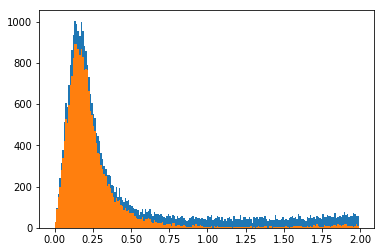

In [250]:
bins = np.arange(0,2,0.01)
plt.hist(min_d2d_help*3600,bins=bins)
plt.hist(min_d2d_prior*3600,bins=bins)
plt.show()

In [258]:
source_class = np.where((min_d2d_help<min_d2d_prior),'nearer_non_prior','nearest_prior')
source_class = np.where((min_d2d_help==min_d2d_prior),'no nearby sources',source_class)
#source_class = np.array(['nearest_prior' for i in range(len(merged_lofar_prior))])
source_class = np.where(source_type==0,'radio_position',source_class)
source_class = np.where(source_type>1,'multiple_prior',source_class)

source_class = source_class.astype('U42')

mask = (source_type>0) & (min_d2d_help>min_d2d_prior)
for i,source in enumerate(source_class):
    if mask[i]==True:

        source_class[i] = source_class[i] + '_with_nearer_non_prior'


In [262]:
class_col = Column(data=source_class,name='prior_type')
merged_lofar_prior.add_column(class_col)

In [267]:
colnames_keep = ['Source_id',
 'Isl_id',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'RA_max',
 'E_RA_max',
 'DEC_max',
 'E_DEC_max',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Maj_img_plane',
 'E_Maj_img_plane',
 'Min_img_plane',
 'E_Min_img_plane',
 'PA_img_plane',
 'E_PA_img_plane',
 'DC_Maj',
 'E_DC_Maj',
 'DC_Min',
 'E_DC_Min',
 'DC_PA',
 'E_DC_PA',
 'DC_Maj_img_plane',
 'E_DC_Maj_img_plane',
 'DC_Min_img_plane',
 'E_DC_Min_img_plane',
 'DC_PA_img_plane',
 'E_DC_PA_img_plane',
 'Isl_Total_flux',
 'E_Isl_Total_flux',
 'Isl_rms',
 'Isl_mean',
 'Resid_Isl_rms',
 'Resid_Isl_mean',
 'S_Code',
 'FLAG_OVERLAP_1',
 'flag_clean_1',
 'Source_Name',
 'lr_fin',
 'lr_dist_fin',
 'lr_index_fin',
 'ra',
 'dec',
 'ra_2',
 'dec_2',
 'help_id',
 'f_spire_250',
 'ferr_spire_250',
 'flag_spire_250',
 'f_spire_350',
 'ferr_spire_350',
 'flag_spire_350',
 'f_spire_500',
 'ferr_spire_500',
 'flag_spire_500',
 'flag_optnir_det',
 'f_mips_24',
 'bayes.dust.luminosity',
 'bayes.dust.luminosity_err',
 'best.universe.redshift',
 'xid+_rerun',
 'prior_type']

In [268]:
merged_lofar_prior = merged_lofar_prior[colnames_keep]

In [269]:
Table.write(merged_lofar_prior,'data/xid+_prepared_cat.fits')